In [1]:
import sys
from pathlib import Path
sys.path.append(Path("../modules/").absolute().__str__())

from data_utils import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import re
from typing import Dict

In [2]:
def load_dataset_and_preprocess(dataset_path: str):
    df = load_dataset(dataset_path)
    df_timeout = df.loc[df['execution'] == 'timeout']
    df_empty = df.drop(df_timeout.index).loc[df['execution'].str.startswith("[]")]
    df_fail = df.drop(df_timeout.index).drop(df_empty.index).loc[df['execution'].str.startswith('exception')]
    df_no_errors = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)
    
    return {
        "base": df,
        "timeout": df_timeout,
        "empty": df_empty,
        "fail": df_fail,
        "no_errors": df_no_errors
    }

In [3]:
path_to_original_executed_dataset = "../datasets/final_queries_v1.1_full_execution_limit_10.parquet.gzip"
# path_to_original_executed_dataset = "../outputs/final_queries_v1.1_full_execution_limit_10.parquet.gzip"
original_dataset = load_dataset_and_preprocess(path_to_original_executed_dataset)

In [4]:
path_to_final_executed_dataset = "../datasets/final_fq17_2/final_fq17_with_limit_10_2/final_fq17-generated_prompt-executed.parquet.gzip"
# path_to_final_executed_dataset = "../outputs/dataset_pipeline/final_fq17_with_limit_10/final_fq17-generated_prompt-executed.parquet.gzip"
final_dataset = load_dataset_and_preprocess(path_to_final_executed_dataset)

path_to_final_executed_dataset_no_limit = "../datasets/final_fq17_2/final_fq17_with_no_limit_2/final_fq17-generated_prompt-executed.parquet.gzip"
# path_to_final_executed_dataset_no_limit = "../outputs/dataset_pipeline/final_fq17/final_fq17-generated_prompt-executed.parquet.gzip"
final_dataset_no_limit = load_dataset_and_preprocess(path_to_final_executed_dataset_no_limit)

Number of timed out requests: 234
Number of failed requests: 113
Number of empty responses: 106
Number of successful responses: 2392
Number of timed out requests: 172
Number of failed requests: 47
Number of empty responses: 115
Number of successful responses: 2504
Number of timed out requests: 186
Number of failed requests: 49
Number of empty responses: 113
Number of successful responses: 2490


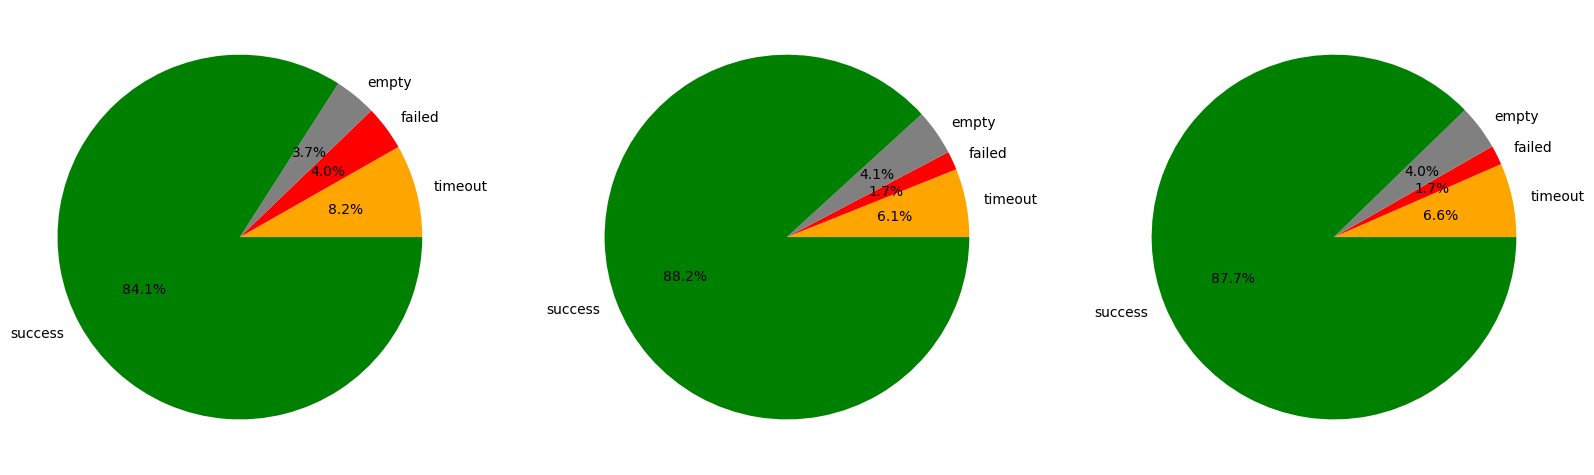

In [5]:
def analyze_responses(datasets, ax):
    print(f"Number of timed out requests: {len(datasets['timeout'])}")
    print(f"Number of failed requests: {len(datasets['fail'])}")
    print(f"Number of empty responses: {len(datasets['empty'])}")
    print(f"Number of successful responses: {len(datasets['no_errors'])}")

    labels = ["timeout", "failed", "empty", "success"]
    sizes  = [
        len(datasets['timeout']),
        len(datasets['fail']),
        len(datasets['empty']),
        len(datasets['no_errors'])
    ]

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])
    
# Call the function with your dataframes as arguments
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 20)
analyze_responses(original_dataset, ax1)
analyze_responses(final_dataset, ax2)
analyze_responses(final_dataset_no_limit, ax3)

In [6]:
def find_error_type(x: str):
    if not isinstance(x, str):
        return None
    
    http_error = re.compile(r"exception: ([0-9]+)")
    module_request_error = re.compile(r"exception: module 'requests.exceptions'")
    server_timeout_error = re.compile(r"java.util.concurrent.TimeoutException")
    empty_error = re.compile(r"exception: query is empty")
    
    http_error_match = http_error.search(x[:20])
    
    if http_error_match != None:
        return http_error_match.group(1)
    
    if module_request_error.search(x[:50]):
        return "requests"
    
    if server_timeout_error.search(x[len(x)-10000:]):
        return "server timeout"
    
    if empty_error.search(x[:100]):
        return "empty query"
    
    return None

def analyse_errors(datasets: Dict):
    datasets['fail']['error_type'] = datasets['fail'].apply(lambda x: find_error_type(x['execution']), axis=1)

    distinct_errors = datasets['fail'].error_type.unique()

    print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
    for err in distinct_errors:
        if err == None:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'].isnull()])}")
        else:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'] == err])}")

    print()

    for err in distinct_errors:
        if err == None:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'].isnull()].iloc[0]['execution'][:256]}")
        else:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'] == err].iloc[0]['execution'][:256]}")

In [7]:
# CAUTION! If there is a link provided in the example, it may be truncated. Therefore leading to another error message !!
# It is truncated for presentation purposes.
analyse_errors(original_dataset)
analyse_errors(final_dataset)
analyse_errors(final_dataset_no_limit)

There is 2 types of errors: 500, 400
Number of 500: 42
Number of 400: 71

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of 400: exception: 400 Client Error: Bad Request for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+schema%3A+%3Chttp%3A%2F%2Fschema.org%2F%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+wdt%3A+%3Chttp%3A
There is 3 types of errors: 500, 400, None
Number of 500: 42
Number of 400: 4
Number of None: 1

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of

error_type
400    71
500    42
Name: count, dtype: int64
error_type
500    42
400     4
Name: count, dtype: int64
error_type
500    42
400     4
Name: count, dtype: int64


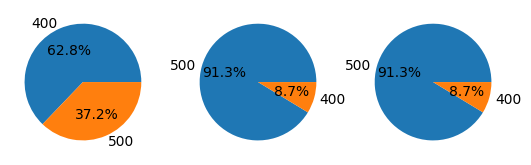

In [8]:
def plot_error_types(datasets: Dict, ax):
    value_counts = datasets['fail']['error_type'].value_counts()
    print(value_counts)

    labels = list(datasets['fail']['error_type'].value_counts().index)
    sizes = list(value_counts)
    
    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plot_error_types(original_dataset, ax1)
plot_error_types(final_dataset, ax2)
plot_error_types(final_dataset_no_limit, ax3)

In [9]:
def generate_index_of_errors(all_errors: pd.Series):
    error_types = sorted(list(all_errors.value_counts().index))
    return {x[0]: i for i, x in enumerate(error_types)}

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    pattern_multiple_same_prefixes = re.compile(r"Multiple prefix declarations for prefix")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
    if pattern_multiple_same_prefixes.search(last_error):
        errors.append("Prefix duplicates")
        
    return errors

def classify_500_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_stackoverflow = re.compile(r"StackOverflowError")
    pattern_geo_input_no_resolve_point = re.compile(r"Input could not be resolved as point")
    pattern_estimated_time_too_long = re.compile(r"The estimated execution time")
    pattern_out_of_memory = re.compile(r"MemoryManagerOutOfMemory")
    pattern_nullpointerexception = re.compile(r"java.lang.NullPointerException")
    pattern_invalid_json_error = re.compile(r"exception: 500 Server Error: the response has an Invalid chunk length")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1] if len(reduced_stack) > 0 else ""
    
    errors = []
    if pattern_stackoverflow.search(last_error):
        errors.append("stack overflow")
    if pattern_geo_input_no_resolve_point.search(last_error):
        errors.append("GeoSpatialSearchException: input could not be resolved as point")
    if pattern_estimated_time_too_long.search(last_error):
        errors.append("estimated time to execute too long")
    if pattern_out_of_memory.search(last_error):
        errors.append("Out of memory")
    if pattern_nullpointerexception.search(last_error):
        errors.append("NullPointerException")
    if pattern_invalid_json_error.search(stack_trace):
        errors.append("Invalid JSON")
        
    return errors

def classify_requests_errors(execution_result):
    pattern = re.compile(r"exception: module 'requests.exceptions' has no attribute 'JSONDecodeError'")
    errors = []
    
    if pattern.search(execution_result[:100]):
        errors.append("no attribute 'JSONDecodeError'")
    
    return errors


def classify_all_errors(execution_result: str):
    if not isinstance(execution_result, str) or execution_result == None:
        return None
    
    error = find_error_type(execution_result)
    
    
    if error == None:
        return None
    elif error == "400":
        return classify_400_errors(execution_result)
    elif error == "500":
        return classify_500_errors(execution_result)
    elif error == "requests":
        return classify_requests_errors(execution_result)
    elif error == "server timeout":
        return ["server timeout"]
    elif error == "empty query":
        return ['empty query']
    
    
    raise NotImplementedError(f"This function is not implemented for errors other than 400, 500, requests, invalid JSON, server timeout, found: {error}")

ERROR_INDEX = {
    "undefined prefix": 0,
    "parse exception due to limit": 1,
    "parse exception": 2,
    "lexical error": 3,
    "non-aggregate variable in select expression": 4,
    "Prefix duplicates": 5,
    "stack overflow": 6,
    "GeoSpatialSearchException: input could not be resolved as point": 7,
    "estimated time to execute too long": 8,
    "Out of memory": 9,
    "no attribute 'JSONDecodeError'": 10,
    "Invalid JSON": 11,
    "server timeout": 12,
    "NullPointerException": 13,
    "empty query": 14
}

original_dataset['fail']['error_classified'] = original_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
original_dataset['fail']['ierror_classified'] = original_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset['fail']['error_classified'] = final_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset['fail']['ierror_classified'] = final_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset_no_limit['fail']['error_classified'] = final_dataset_no_limit['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset_no_limit['fail']['ierror_classified'] = final_dataset_no_limit['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

error_classified
[lexical error]                                  36
[parse exception]                                16
[undefined prefix]                               16
[parse exception due to limit]                    2
[non-aggregate variable in select expression]     1
Name: count, dtype: int64
error_classified
[parse exception]                 3
[parse exception due to limit]    1
Name: count, dtype: int64
error_classified
[parse exception]    4
Name: count, dtype: int64


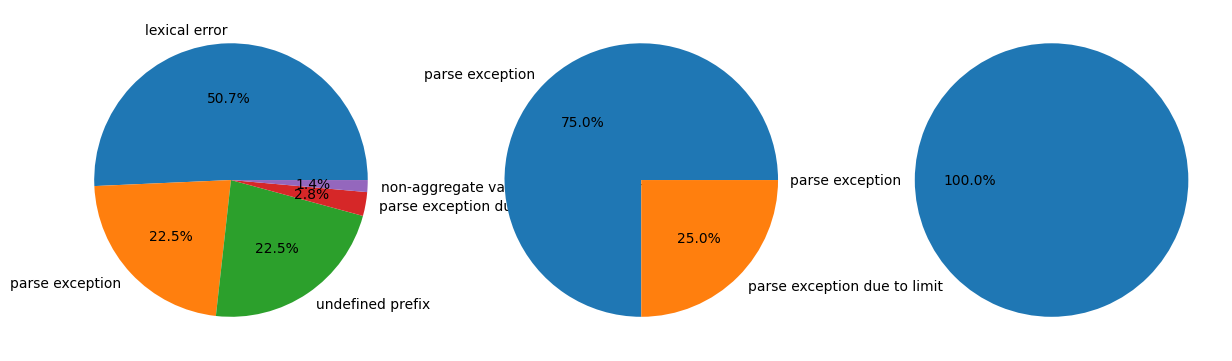

In [10]:
def plot_error_400(datasets, ax):
    df_error400 = datasets['fail'].loc[datasets['fail']['error_type'] == '400']

    value_counts = df_error400.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error400.error_classified.value_counts().index)))
    sizes = list(value_counts)

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 20))
plot_error_400(original_dataset, ax1)
plot_error_400(final_dataset, ax2)
plot_error_400(final_dataset_no_limit, ax3)

error_classified
[stack overflow]                                                     34
[GeoSpatialSearchException: input could not be resolved as point]     7
[Out of memory]                                                       1
Name: count, dtype: int64
error_classified
[stack overflow]                                                     35
[GeoSpatialSearchException: input could not be resolved as point]     7
Name: count, dtype: int64
error_classified
[stack overflow]                                                     35
[GeoSpatialSearchException: input could not be resolved as point]     7
Name: count, dtype: int64


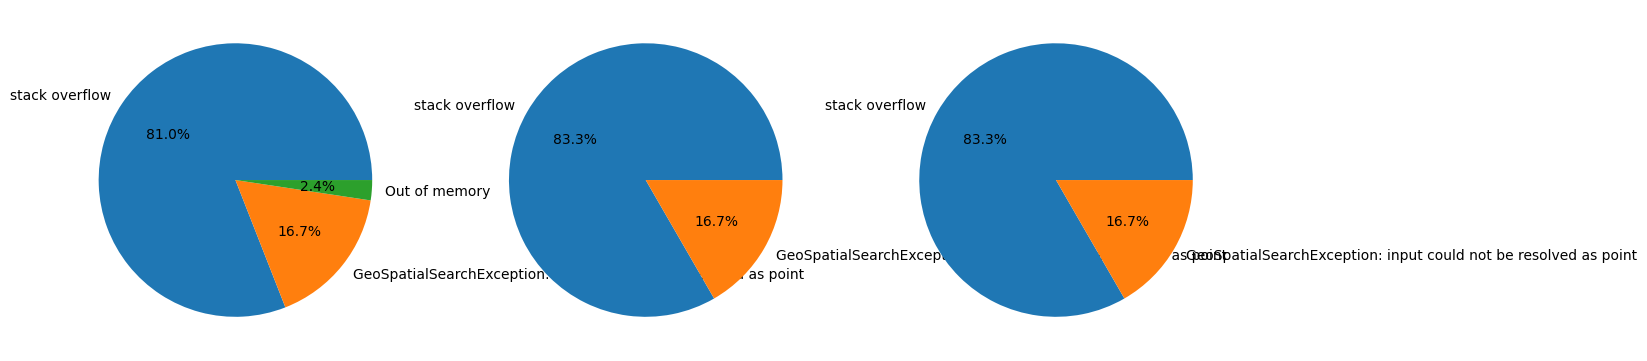

In [11]:
def plot_error_500(datasets, ax):
    df_error500 = datasets['fail'].loc[datasets['fail']['error_type'] == '500']

    value_counts = df_error500.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error500.error_classified.value_counts().index)))
    sizes = list(value_counts)

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 20))
plot_error_500(original_dataset, ax1)
plot_error_500(final_dataset, ax2)
plot_error_500(final_dataset_no_limit, ax3)

# To Delete

In [12]:
f_w_10 = final_dataset["fail"]

In [13]:
final_dataset["fail"]["error_type"].value_counts(dropna=False)

error_type
500     42
400      4
None     1
Name: count, dtype: int64

In [14]:
final_dataset["fail"].loc[final_dataset["fail"]["error_type"] == "500"].head()

,query,description,context,prompt,num_tokens,start_with_SELECT,query_templated,basic_prompt,basic_num_tokens,basic_result,...,templated_num_tokens,templated_result,templated_full_answer,templated_is_skipped,templated_is_prompt_too_long,execution,executed_query,error_type,error_classified,ierror_classified
index,,,,,,,,,,,,,,,,,,,,,
24,SELECT ?iso ?countryLabel (SUM(?stars) as ?sta...,,Not Economics\nStars in flag versus fertility,<s>[INST] <<SYS>>This is a conversation betwee...,423,True,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,"[INST] QUERY=""SELECT ?iso ?countryLabel (SUM(?...",384,"[""Write a SparQL query to retrieve the ISO cod...",...,554,"[""Write a SparQL query to find the ISO codes, ...","{'content': ' 1. ""Write a SparQL query to find...",False,False,exception: 500 Server Error: Internal Server E...,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,500,[stack overflow],6.0
413,SELECT ?manufacturer ?manufacturerLabel (SUM(?...,,Ways to reduce multiplicity\nSources of multip...,<s>[INST] <<SYS>>This is a conversation betwee...,446,True,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,"[INST] QUERY=""SELECT ?manufacturer ?manufactur...",404,"[""Write a query to find the total number of gu...",...,489,"[""Write a query to find the total number of gu...","{'content': ' 1. ""Write a query to find the to...",False,False,exception: 500 Server Error: Internal Server E...,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,500,[stack overflow],6.0
560,SELECT ?continent ?river ?continentLabel ?rive...,,Geography \n Rivers \n Longest river of ea...,<s>[INST] <<SYS>>This is a conversation betwee...,342,True,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,"[INST] QUERY=""SELECT ?continent ?river ?contin...",302,"[""Write a SparQL query to find and display the...",...,389,"[""Find and display the longest river in each c...","{'content': ' 1. ""Find and display the longest...",False,False,exception: 500 Server Error: Internal Server E...,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,500,[stack overflow],6.0
629,SELECT ?object ?objectLabel ?mass WHERE {\n{\n...,,Science \n Objects with most mass,<s>[INST] <<SYS>>This is a conversation betwee...,288,True,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,"[INST] QUERY=""SELECT ?object ?objectLabel ?mas...",252,"[""Find the top 100 objects with the highest ma...",...,370,"[""Find the top 100 objects with the highest ma...","{'content': ' 1. ""Find the top 100 objects wit...",False,False,exception: 500 Server Error: Internal Server E...,PREFIX bd: <http://www.bigdata.com/rdf#>\nPREF...,500,[stack overflow],6.0
657,SELECT (SAMPLE(?seasonNumber) AS ?seasonNumber...,All Law & Order episodes on Wikidata.\n//en.wi...,Culture \n Film and television \n Law & Or...,<s>[INST] <<SYS>>This is a conversation betwee...,670,True,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,"[INST] QUERY=""SELECT (SAMPLE(?seasonNumber) AS...",630,"[""Write a SparQL query to retrieve the title, ...",...,778,"[""Write a SparQL query to retrieve the title, ...","{'content': ' 1. ""Write a SparQL query to retr...",False,False,exception: 500 Server Error: Internal Server E...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,500,[stack overflow],6.0


In [22]:
what = final_dataset_no_limit["fail"].loc[final_dataset_no_limit["fail"]["error_type"].isnull()]

In [16]:
from execution_utils import prepare_and_send_query_to_api

In [17]:
query = final_dataset["timeout"].iloc[0]['query']
print(query)

SELECT (COUNT(?article) AS ?count)
WHERE {
?article wdt:P31/wdt:P279* wd:Q13442814
}


In [18]:
res = prepare_and_send_query_to_api(
    query=query,
    index=0,
    num_of_rows=0,
    answer_limit=0,
    timeout_limit=300,
    do_add_limit=False,
    do_print=False
)
res

('PREFIX wd: <http://www.wikidata.org/entity/>\nPREFIX wdt: <http://www.wikidata.org/prop/direct/>\n\nSELECT (COUNT(?article) AS ?count)\nWHERE {\n?article wdt:P31/wdt:P279* wd:Q13442814\n}',
 'timeout')

In [19]:
print(res[1])

timeout


In [20]:
classify_500_errors(res[1])

[]